In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pingouin as pg

%matplotlib inline

# Import the data

In [2]:
path_cohort_1 = '/home/ds/Ntrk2_KOs/2018_12/EPM/tracking_results_EPM.xlsx'
df_1 = pd.read_excel(path_cohort_1)

In [3]:
path_cohort_2 = '/home/ds/Ntrk2_KOs/2019_07/EPM/tracking_results_epm.xlsx'
df_2 = pd.read_excel(path_cohort_2)

In [4]:
path_cohort_3 = '/home/ds/Ntrk2_KOs/2019_12/EPM/EMP_results_new.xlsx'
df_3 = pd.read_excel(path_cohort_3)


# Preprocess the data:

### Adjust column names for cohort 1 to match those of cohort 2 & 3:

In [5]:
l_rename_columns = ['Datei', 'Nr.', 'Analyseintervall', 'von', 'bis', 'Tier Nr.', 'Gruppe',
'time_open_arms', 'visits_open_arms', 'distance_open_arms',
'Zeit %Total(o) (Z)', 'Zeit %Global(o) (Z)', 'Besuche %Total(o) (Z)',
'time_closed_arms', 'visits_closed_arms', 'distance_closed_arms',
'Zeit %Total(g) (Z)', 'Zeit %Global(g) (Z)', 'Besuche %Total(g) (Z)',
'Totalzeit', 'Totalstrecke', 'Globalzeit', 
'Globalstrecke', 'Latenz(o) (Z)', 'Latenz(g) (Z)', 'Latenz(o+g) (Z)',
'Bewegungsschwelle', 'Minimale Aufenthaltsdauer']

df_1.columns = l_rename_columns

df_1['Totalbesuche'] = df_1['visits_open_arms'] + df_1['visits_closed_arms']

In [6]:
l_columns_for_total = ['time_open_arms', 'visits_open_arms', 'distance_open_arms', 'time_closed_arms', 'visits_closed_arms', 'distance_closed_arms', 'Totalzeit', 'Totalbesuche', 'Totalstrecke']

In [7]:
# For df_2 and df_3, the data from the individual arms has to be aggregated first:
for df in [df_2, df_3]:
#for df in [df_2]:
    # Aggregate data from both open arms:
    df['time_open_arms'] = df['Zeit I01 Open-up'] + df['Zeit I03 Open-down']
    df['visits_open_arms'] = df['Besuche I01 Open-up'] + df['Besuche I03 Open-down']
    df['distance_open_arms'] = df['Strecke I01 Open-up'] + df['Strecke I03 Open-down']

    # Aggregate data from both closed arms:
    df['time_closed_arms'] = df['Zeit I02 Closed-right'] + df['Zeit I04 Closed-left']
    df['visits_closed_arms'] = df['Besuche I02 Closed-right'] + df['Besuche I04 Closed-left']
    df['distance_closed_arms'] = df['Strecke I02 Closed-right'] + df['Strecke I04 Closed-left']



    
# Now we can work with all three DataFrames in the same way
l_raw_dfs = [df_1, df_2, df_3]
#_raw_dfs = [df_1, df_2]
l_preprocessed_dfs = []

for cohort in range(len(l_raw_dfs)):
    # Select DataFrame and assign cohort ID:
    df = l_raw_dfs[cohort]

    # Calculate the total session information
    for mouse in df['Tier Nr.'].unique():
        group = df.loc[df['Tier Nr.'] ==  mouse, 'Gruppe'].values[0]
        row = df.shape[0]
        df.loc[row] = np.NaN
        df.loc[row, ['Analyseintervall', 'Tier Nr.', 'Gruppe']] = ['total', mouse, group]
        for column in l_columns_for_total:
            df.loc[row, column] = df.loc[(df['Tier Nr.'] == mouse) & (df['Analyseintervall'] != 'total'), column].sum()
    
    # Calculate the percentages of time, visits and distance in the open arms:
    df['%time_open_arms'] = df['time_open_arms'] / df['Totalzeit'] * 100
    df['%visits_open_arms'] = df['visits_open_arms'] / df['Totalbesuche'] * 100
    df['%distance_open_arms'] = df['distance_open_arms'] / df['Totalstrecke'] * 100

    # Add information about the cohort:
    df.insert(7, 'Kohorte', cohort)
    
    # Append preprocessed DataFrame to list to create Master DataFrame:
    l_preprocessed_dfs.append(df)

df = pd.concat(l_preprocessed_dfs)
df = df.reset_index(drop=True)
df.head()

,Datei,Nr.,Analyseintervall,von,bis,Tier Nr.,Gruppe,Kohorte,time_open_arms,visits_open_arms,...,Zeit I04 Closed-left,Strecke I04 Closed-left,Besuche I04 Closed-left,Latenz I04 Closed-left,Zeit I05 Center,Strecke I05 Center,Besuche I05 Center,Latenz I05 Center,Total%,Globalgeschwindigkeit
0,C:\Users\ag_blum\Desktop\Dennis\Ntrk2 Rohr\EPM...,1.0,1,0.0,60000.0,#01,tg,0,27834.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,60000.0,120000.0,#01,tg,0,5029.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.0,3,120000.0,180000.0,#01,tg,0,7289.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.0,4,180000.0,240000.0,#01,tg,0,4572.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.0,5,240000.0,300000.0,#01,tg,0,9625.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.to_csv('EPM_all_cohorts.csv')

# __Calculate stats:__

In [10]:
d_stats = {}

# List of measures (=column names) for which stats will be calculated:
l_measures = ['Totalstrecke', '%time_open_arms', '%visits_open_arms', '%distance_open_arms']


for measure in l_measures:
    #Setup new dictionary in d_stats:
    d_stats[measure] = {}

    # Get data:
    data_wt = list(df.loc[(df['Gruppe'] == 'wt') & (df['Analyseintervall'] == 'total'), measure].values)
    data_tg = list(df.loc[(df['Gruppe'] == 'wt') & (df['Analyseintervall'] == 'total'), measure].values)
    
    # Store data for annotations in plots:
    d_stats[measure]['data_wt'] = data_wt
    d_stats[measure]['data_tg'] = data_tg
    
    # Test for normal distribution (Shapiro):
    d_stats[measure]['normality_wt'] = (pg.normality(data_wt).loc[0, 'normal'], pg.normality(data_wt).loc[0, 'pval'].round(3))
    d_stats[measure]['normality_tg'] = (pg.normality(data_tg).loc[0, 'normal'], pg.normality(data_tg).loc[0, 'pval'].round(3))


    # Test for homoscesdasticity (Levenes):
    d_stats[measure]['equal_var'] = (pg.homoscedasticity([data_wt, data_tg]).loc['levene', 'equal_var'], pg.homoscedasticity([data_wt, data_tg]).loc['levene', 'pval'].round(3))

    # Perform either parametric or non-parametric pairwise test:
    if (d_stats[measure]['normality_wt'][0] == True) & (d_stats[measure]['normality_tg'][0] == True) & (d_stats[measure]['equal_var'][0] == True):
        d_stats[measure]['pairwise_test'] = ('ttest', pg.ttest(x=data_wt, y=data_tg).loc['T-test', 'p-val'].round(4) <= 0.05, pg.ttest(x=data_wt, y=data_tg).loc['T-test', 'p-val'].round(4))
    else:
        d_stats[measure]['pairwise_test'] = ('MWU', pg.mwu(x=data_wt, y=data_tg).loc['MWU', 'p-val'].round(4) <= 0.05, pg.mwu(x=data_wt, y=data_tg).loc['MWU', 'p-val'].round(4))

# __Plot results:__

### Setup figure design and annotate_stats function:

In [12]:
SMALL_SIZE = 16
MEDIUM_SIZE = 17
BIGGER_SIZE = 19
LINE_WIDTH = 2
SIZE = 9

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels 
plt.rc('axes', linewidth=LINE_WIDTH)     # linewidth of x and y axis
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('xtick.major', size=10)    # linewidth of x ticks
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick.major', size=10)    # linewidth of y ticks
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def annotate_stats(key, axis, subplot):
    data_wt = d_stats[key]['data_wt']
    data_tg = d_stats[key]['data_tg']
    max_total = max([max(data_wt), max(data_tg)])
    x1, x2 = 0, 1
    y, h, col = max_total + max_total * 0.05, max_total * 0.05, 'k'
    stars = '$\it{n.s.}$'
    if d_stats[key]['pairwise_test'][2] < 0.001:
        subplot = axis.plot([x1, x2], [y+h, y+h], lw=1.5, c=col)
        stars = '***'
    elif d_stats[key]['pairwise_test'][2] < 0.01:
        subplot = axis.plot([x1, x2], [y+h, y+h], lw=1.5, c=col)
        stars = '**'
    elif d_stats[key]['pairwise_test'][2] < 0.05:
        subplot = axis.plot([x1, x2], [y+h, y+h], lw=1.5, c=col)
        stars = '*'      
    subplot = axis.text((x1+x2)*.5, max_total, stars, ha='center', va='bottom', color=col)
    labels = ['WT', '$\it{Ntrk2}$$^{+/-}$']
    axis.axes.set_xticklabels(labels)
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.axes.set_ylabel('latency [s]')

## Total distance travelled:

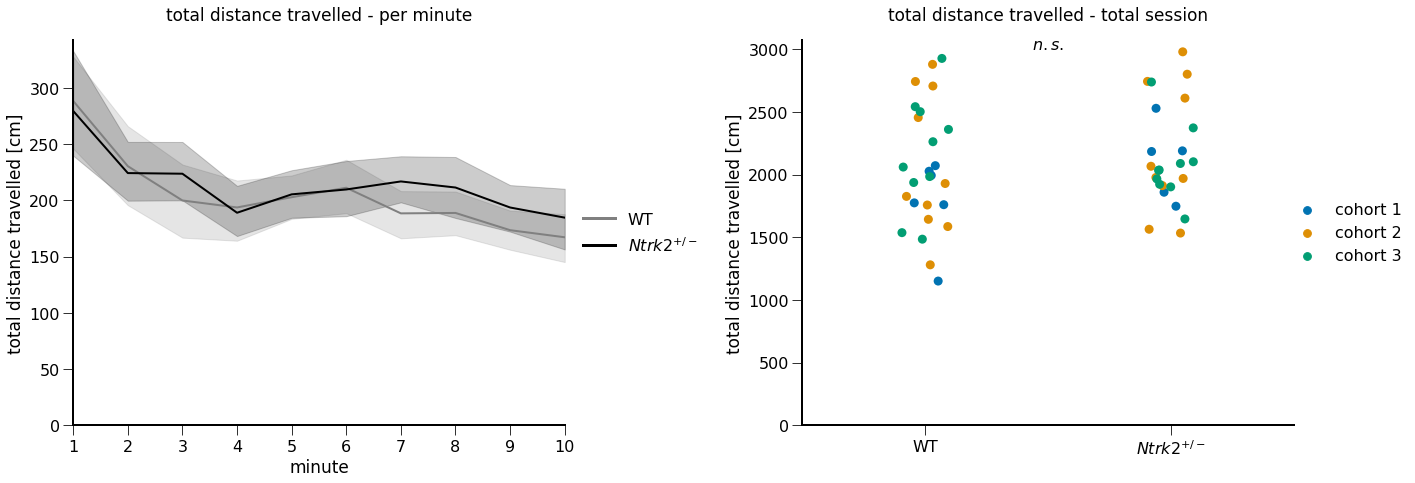

In [19]:
data_col = 'Totalstrecke'

fig = plt.figure(figsize=(20, 7), facecolor='w')
gs = fig.add_gridspec(1,2)



# Plot data for individual intervalls:
ax1 = fig.add_subplot(gs[0,0])
sns.lineplot(data=df.loc[df['Analyseintervall'] != 'total'], x='Analyseintervall', y=data_col, hue="Gruppe", palette=['gray', 'black'], ax=ax1, linewidth=2)

# Adjust axes, labels, and title:
plt.title('total distance travelled - per minute', pad = 20)
plt.ylim(0)
plt.xlim(1,10)
plt.ylabel('total distance travelled [cm]')
plt.xlabel('minute')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Adjust legend:
handles, labels = ax1.get_legend_handles_labels()
for ha in handles:
    ha = ha.set_linewidth(3)
labels = ['WT', '$\it{Ntrk2}$$^{+/-}$']
ax1.legend(handles, labels, ncol=1, frameon=False, loc='center right', bbox_to_anchor=(1.3, 0.5))



# Plot data for total session and annotate states:
ax2 = fig.add_subplot(gs[0,1])
plt_total = sns.stripplot(data=df.loc[df['Analyseintervall'] == 'total'], x='Gruppe', y=data_col, hue='Kohorte', palette='colorblind', size=SIZE, ax=ax2)
annotate_stats(data_col, ax2, plt_total)

# Adjust axes, labels, and title:
plt.title('total distance travelled - total session', pad = 20)
plt.ylabel('total distance travelled [cm]')
plt.ylim(0)
plt.xlabel('')

# Adjust legend:
plt.legend(title='')
current_handles, current_labels = plt.gca().get_legend_handles_labels()
current_labels = ['cohort 1', 'cohort 2', 'cohort 3']
ax2.legend(current_handles, current_labels, ncol=1, loc='center right', frameon=False, bbox_to_anchor=(1.25, 0.5))


# Save and display figure:
plt.tight_layout()
plt.savefig('EMP_total_distance.png', dpi=300)
plt.show()


## Time in open arms:

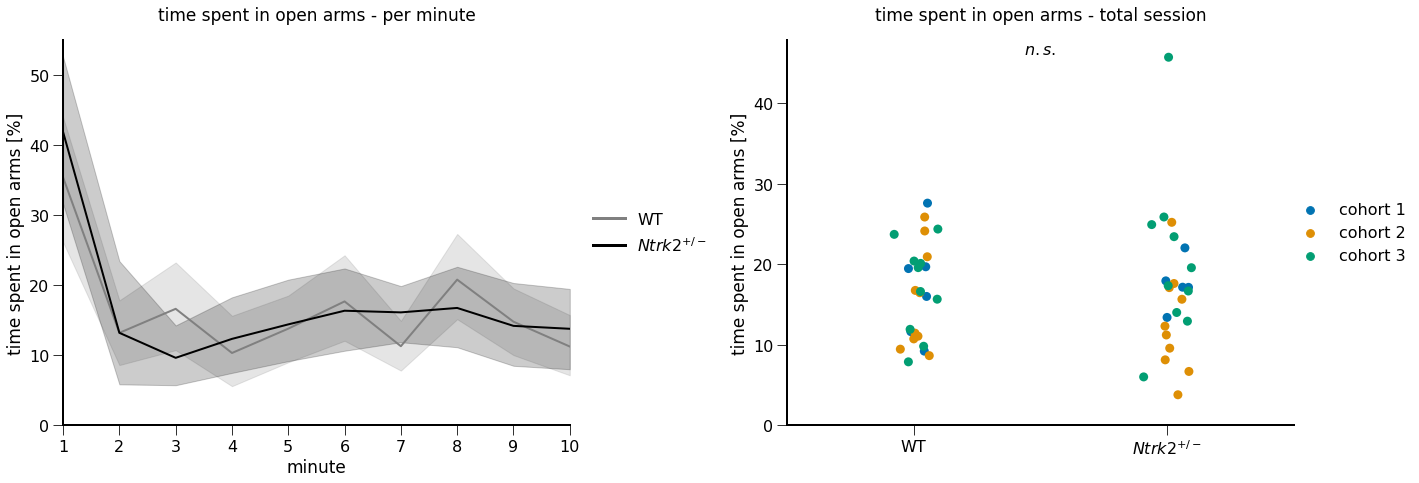

In [16]:
data_col = '%time_open_arms'

fig = plt.figure(figsize=(20, 7), facecolor='w')
gs = fig.add_gridspec(1,2)



# Plot data for individual intervalls:
ax1 = fig.add_subplot(gs[0,0])
sns.lineplot(data=df.loc[df['Analyseintervall'] != 'total'], x='Analyseintervall', y=data_col, hue="Gruppe", palette=['gray', 'black'], ax=ax1, linewidth=2)

# Adjust axes, labels, and title:
plt.title('time spent in open arms - per minute', pad = 20)
plt.ylim(0)
plt.xlim(1,10)
plt.ylabel('time spent in open arms [%]')
plt.xlabel('minute')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Adjust legend:
handles, labels = ax1.get_legend_handles_labels()
for ha in handles:
    ha = ha.set_linewidth(3)
labels = ['WT', '$\it{Ntrk2}$$^{+/-}$']
ax1.legend(handles, labels, ncol=1, frameon=False, loc='center right', bbox_to_anchor=(1.3, 0.5))



# Plot data for total session and annotate states:
ax2 = fig.add_subplot(gs[0,1])
plt_total = sns.stripplot(data=df.loc[df['Analyseintervall'] == 'total'], x='Gruppe', y=data_col, hue='Kohorte', palette='colorblind', size=SIZE, ax=ax2)
annotate_stats(data_col, ax2, plt_total)

# Adjust axes, labels, and title:
plt.title('time spent in open arms - total session', pad = 20)
plt.ylabel('time spent in open arms [%]')
plt.ylim(0)
plt.xlabel('')

# Adjust legend:
plt.legend(title='')
current_handles, current_labels = plt.gca().get_legend_handles_labels()
current_labels = ['cohort 1', 'cohort 2', 'cohort 3']
ax2.legend(current_handles, current_labels, ncol=1, loc='center right', frameon=False, bbox_to_anchor=(1.25, 0.5))


# Save and display figure:
plt.tight_layout()
plt.savefig('EPM_time_open_arms.png', dpi=300)
plt.show()


## Visits to open arms:

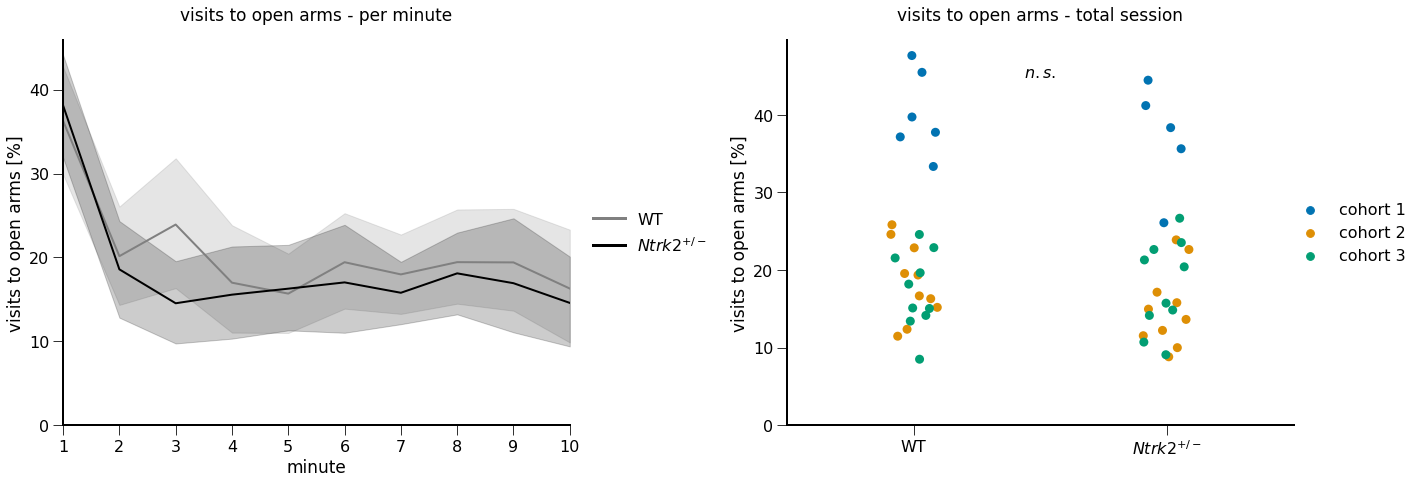

In [17]:
data_col = '%visits_open_arms'

fig = plt.figure(figsize=(20, 7), facecolor='w')
gs = fig.add_gridspec(1,2)



# Plot data for individual intervalls:
ax1 = fig.add_subplot(gs[0,0])
sns.lineplot(data=df.loc[df['Analyseintervall'] != 'total'], x='Analyseintervall', y=data_col, hue="Gruppe", palette=['gray', 'black'], ax=ax1, linewidth=2)

# Adjust axes, labels, and title:
plt.title('visits to open arms - per minute', pad = 20)
plt.ylim(0)
plt.xlim(1,10)
plt.ylabel('visits to open arms [%]')
plt.xlabel('minute')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Adjust legend:
handles, labels = ax1.get_legend_handles_labels()
for ha in handles:
    ha = ha.set_linewidth(3)
labels = ['WT', '$\it{Ntrk2}$$^{+/-}$']
ax1.legend(handles, labels, ncol=1, frameon=False, loc='center right', bbox_to_anchor=(1.3, 0.5))



# Plot data for total session and annotate states:
ax2 = fig.add_subplot(gs[0,1])
plt_total = sns.stripplot(data=df.loc[df['Analyseintervall'] == 'total'], x='Gruppe', y=data_col, hue='Kohorte', palette='colorblind', size=SIZE, ax=ax2)
annotate_stats(data_col, ax2, plt_total)

# Adjust axes, labels, and title:
plt.title('visits to open arms - total session', pad = 20)
plt.ylabel('visits to open arms [%]')
plt.ylim(0)
plt.xlabel('')

# Adjust legend:
plt.legend(title='')
current_handles, current_labels = plt.gca().get_legend_handles_labels()
current_labels = ['cohort 1', 'cohort 2', 'cohort 3']
ax2.legend(current_handles, current_labels, ncol=1, loc='center right', frameon=False, bbox_to_anchor=(1.25, 0.5))


# Save and display figure:
plt.tight_layout()
plt.savefig('EPM_visits_open_arms.png', dpi=300)
plt.show()


## Distance in open arms:

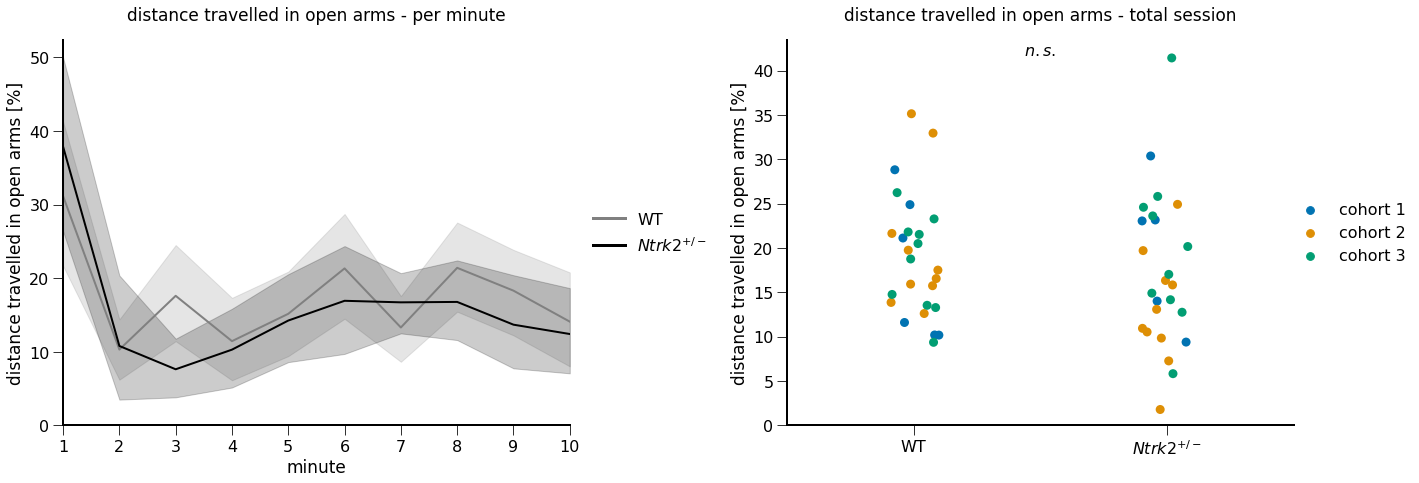

In [18]:
data_col = '%distance_open_arms'

fig = plt.figure(figsize=(20, 7), facecolor='w')
gs = fig.add_gridspec(1,2)



# Plot data for individual intervalls:
ax1 = fig.add_subplot(gs[0,0])
sns.lineplot(data=df.loc[df['Analyseintervall'] != 'total'], x='Analyseintervall', y=data_col, hue="Gruppe", palette=['gray', 'black'], ax=ax1, linewidth=2)

# Adjust axes, labels, and title:
plt.title('distance travelled in open arms - per minute', pad = 20)
plt.ylim(0)
plt.xlim(1,10)
plt.ylabel('distance travelled in open arms [%]')
plt.xlabel('minute')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Adjust legend:
handles, labels = ax1.get_legend_handles_labels()
for ha in handles:
    ha = ha.set_linewidth(3)
labels = ['WT', '$\it{Ntrk2}$$^{+/-}$']
ax1.legend(handles, labels, ncol=1, frameon=False, loc='center right', bbox_to_anchor=(1.3, 0.5))



# Plot data for total session and annotate states:
ax2 = fig.add_subplot(gs[0,1])
plt_total = sns.stripplot(data=df.loc[df['Analyseintervall'] == 'total'], x='Gruppe', y=data_col, hue='Kohorte', palette='colorblind', size=SIZE, ax=ax2)
annotate_stats(data_col, ax2, plt_total)

# Adjust axes, labels, and title:
plt.title('distance travelled in open arms - total session', pad = 20)
plt.ylabel('distance travelled in open arms [%]')
plt.ylim(0)
plt.xlabel('')

# Adjust legend:
plt.legend(title='')
current_handles, current_labels = plt.gca().get_legend_handles_labels()
current_labels = ['cohort 1', 'cohort 2', 'cohort 3']
ax2.legend(current_handles, current_labels, ncol=1, loc='center right', frameon=False, bbox_to_anchor=(1.25, 0.5))


# Save and display figure:
plt.tight_layout()
plt.savefig('EPM_distance_open_arms.png', dpi=300)
plt.show()
